In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [40]:
import os
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import io

from torchvision.utils import make_grid 
from torchsummary import summary
from torch import nn
from PIL import Image
from IPython.display import display, HTML
from k12libs.utils.nb_easy import k12ai_get_top_dir
from k12libs.utils.nb_easy import K12AI_PRETRAINED_ROOT
from k12libs.utils.nb_dataset import k12ai_load_image, k12ai_load_model
from k12libs.k12ai.common.vis_helper import generate_model_graph, FilterFeatureMaps

In [3]:
# Visualize feature maps
kernels_ = {}
activation = {}
def get_activation(name):
    def hook(model, input, output):
        kernels_[name] = model.weight.detach().clone()
        activation[name] = output.detach()
    return hook

In [4]:
class Extractor(nn.Module):
    def __init__(self):
        super(Extractor, self).__init__()
        self.extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 6, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 6, 2)
        )

    def forward(self, x):
        x = self.extractor(x)
        x = self.decoder(x)
        return x

In [5]:
model = Extractor()
print(model)

Extractor(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(6, 6), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(6, 6), stride=(2, 2))
  )
)


In [6]:
model.extractor[0].register_forward_hook(get_activation('ext_conv1'))
model.extractor[3].register_forward_hook(get_activation('ext_conv2'))
x = torch.randn(1, 3, 96, 96)
output = model(x)
print(output.shape)

torch.Size([1, 3, 96, 96])


In [7]:
# HTML(generate_model_graph(model, x))
# summary(model, (3, 96, 96), device='cpu')

torch.Size([1, 64, 96, 96])
torch.Size([64, 96, 96])


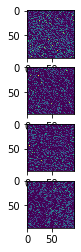

In [8]:
print(activation['ext_conv1'].shape)
act = activation['ext_conv1'].squeeze()
print(act.shape)
num_plot = 4
fig, axarr = plt.subplots(min(act.size(0), num_plot))
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].imshow(act[idx])

torch.Size([128, 44, 44])


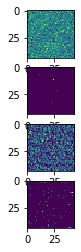

In [9]:
act = activation['ext_conv2'].squeeze()
print(act.shape)
num_plot = 4
fig, axarr = plt.subplots(min(act.size(0), num_plot))
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].imshow(act[idx])

In [10]:
model.extractor[0].in_channels, model.extractor[0].out_channels

(3, 64)

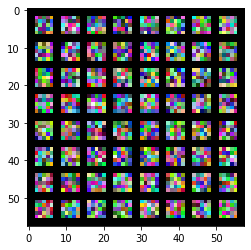

In [11]:
kernels = model.extractor[0].weight.detach().clone()

# 等价于:normalize = True
# kernels = kernels - kernels.min()
# kernels = kernels / kernels.max()
img = make_grid(kernels, normalize=True)
plt.imshow(img.permute(1, 2, 0))

In [12]:
kernels.shape

torch.Size([64, 3, 5, 5])

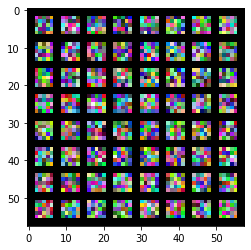

In [13]:
img = make_grid(kernels_['ext_conv1'], normalize=True)
plt.imshow(img.permute(1, 2, 0))

# <div align='center'> VGG16 </div>

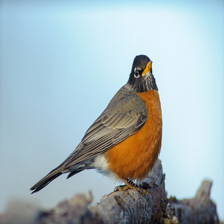

torch.Size([1, 3, 224, 224])

In [14]:
image, raw_image = k12ai_load_image(
    'bird.jpg',
    resize=(224, 224),
    # mean = [0.485, 0.456, 0.406],
    # std = [0.229, 0.224, 0.225]
)
display(raw_image)

images = image.unsqueeze(0)
images.shape

In [15]:
vgg16_model = k12ai_load_model('vgg16')
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Visualize feature maps
activation = {}
layers = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
        layers[name] = model
    return hook
# print(model._modules)
vgg16_model.features[0].register_forward_hook(get_activation('features.0'))
vgg16_model.features[2].register_forward_hook(get_activation('features.2'))
vgg16_model.features[5].register_forward_hook(get_activation('features.5'))
vgg16_model.features[14].register_forward_hook(get_activation('features.14'))

In [17]:
output = vgg16_model(images)

In [18]:
activation['features.0'].shape, activation['features.14'].shape

(torch.Size([1, 64, 224, 224]), torch.Size([1, 256, 56, 56]))

In [19]:
feature_cnn_0 = activation['features.0'].squeeze()[0:10].cpu()
feature_cnn_2 = activation['features.2'].squeeze()[0:10].cpu()
feature_cnn_5 = activation['features.5'].squeeze()[0:10].cpu()
feature_cnn_0.shape, feature_cnn_2.shape, feature_cnn_5.shape

(torch.Size([10, 224, 224]),
 torch.Size([10, 224, 224]),
 torch.Size([10, 112, 112]))

In [20]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])

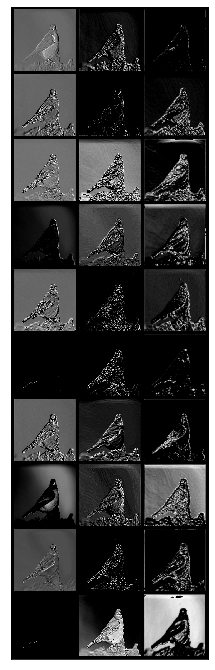

In [21]:
image_list = []
for i in range(10):
    for fmap in (feature_cnn_0, feature_cnn_2, feature_cnn_5):
        image_list.append(transforms(fmap[i]))
grid_images = make_grid(image_list, nrow=3, padding=10, normalize=True, scale_each=True)
grid_images.shape
plt.figure(figsize=(12, 12))
plt.xticks([])
plt.yticks([])
plt.imshow(grid_images.permute(1, 2, 0))

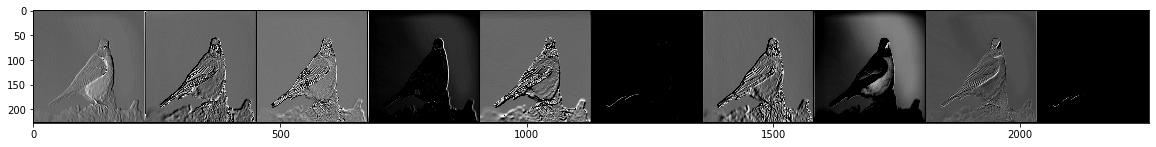

In [22]:
image_list = []
for i in range(10):
    image_list.append(transforms(feature_cnn_0[i]))
grid_images = make_grid(image_list, nrow=10, normalize=True, scale_each=True)
plt.figure(figsize=(20,20))
plt.imshow(grid_images.permute(1, 2, 0))

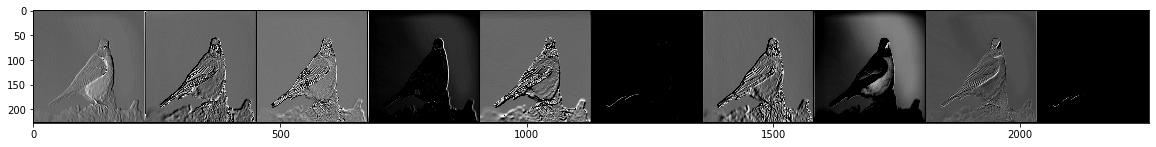

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(grid_images.permute(1, 2, 0), cmap='rainbow')

## Filters(Kernels)

In [24]:
layers

{'features.0': Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.2': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.5': Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 'features.14': Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))}

In [25]:
ws0 = layers['features.0'].weight.detach().clone().cpu()
ws2 = layers['features.2'].weight.detach().clone().cpu()
ws5 = layers['features.5'].weight.detach().clone().cpu()

print(ws0.shape, ws2.shape, ws5.shape)
# a = make_grid(ws0, normalize=True)
# print(a.shape)
# plt.figure(figsize=(20,20))
# plt.imshow(a.permute(1, 2, 0), cmap='rainbow')

torch.Size([64, 3, 3, 3]) torch.Size([64, 64, 3, 3]) torch.Size([128, 64, 3, 3])


torch.Size([3, 13, 41])


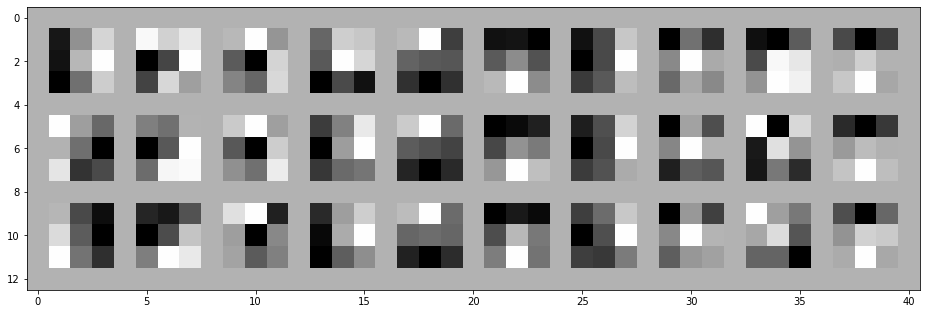

In [43]:
def generate_grid(kernels, rank='TB'):
    tensors = []
    outchnnl_num = min(kernels.size(0), 10)
    inchnnl_num = min(kernels.size(1), 10)
    if rank == 'LR':
        for outchnnl in range(outchnnl_num):
            for inchnnl in range(inchnnl_num):
                tensors.append(kernels[outchnnl, inchnnl, ...].unsqueeze(0))
        nrow = inchnnl_num
    else:
        for inchnnl in range(inchnnl_num):
            for outchnnl in range(outchnnl_num):
                tensors.append(kernels[outchnnl, inchnnl, ...].unsqueeze(0))
        nrow = outchnnl_num
    return make_grid(tensors, normalize=True, nrow=nrow, padding=1, scale_each=True, pad_value=0.7)

grid = generate_grid(ws0)
print(grid.shape)
plt.figure(figsize=(16,16))
plt.imshow(grid.permute(1, 2, 0), alpha=1, interpolation='none', cmap='gray', vmin = 0, vmax = 255)

torch.Size([3, 41, 13])


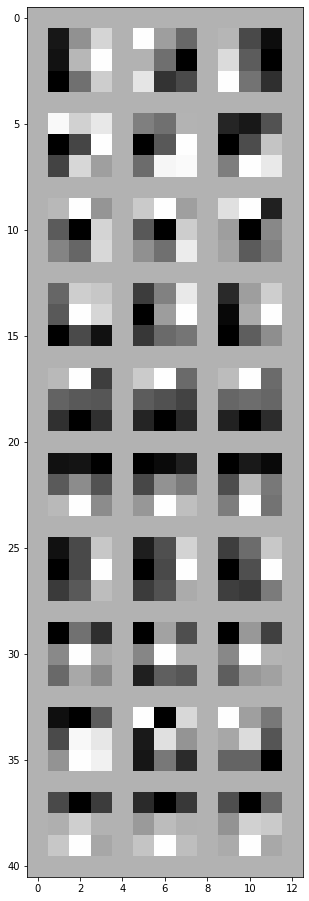

In [27]:
grid = generate_grid(ws0, rank='LR')
print(grid.shape)
plt.figure(figsize=(16,16))
plt.imshow(grid.permute(1, 2, 0)) #, interpolation='none', cmap='gray', vmin = 0, vmax = 255)

------------------------------

# Test FeatureMaps

In [28]:
for name, module in vgg16_model.named_modules():
    if isinstance(module, nn.Conv2d):
        print(name)

features.0
features.2
features.5
features.7
features.10
features.12
features.14
features.17
features.19
features.21
features.24
features.26
features.28


In [29]:
vgg16_model.features[0].weight.shape, vgg16_model.features[7].weight.shape

(torch.Size([64, 3, 3, 3]), torch.Size([128, 128, 3, 3]))

tensor([15], device='cuda:0')


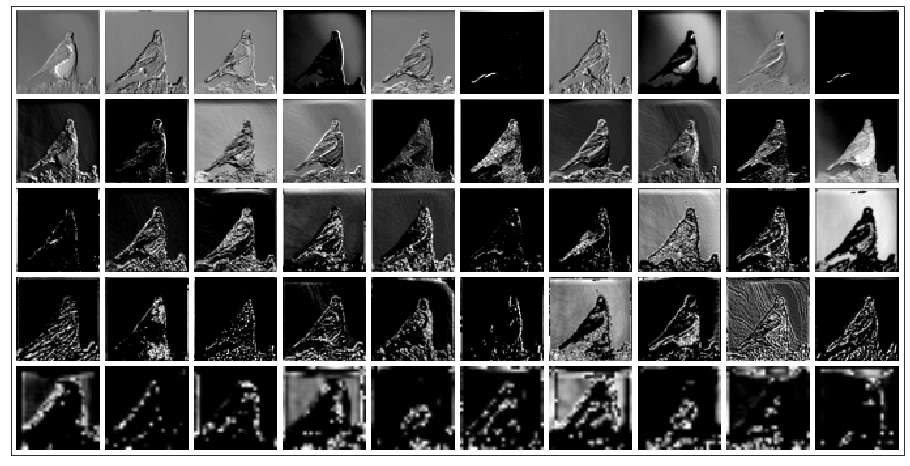

In [30]:
fm = FilterFeatureMaps(vgg16_model, ['features.0', 'features.2', 'features.5', 'features.7', 'features.17'], True)
fm.forward(images)
fgrid, kgrids = fm.generate(rank='TB')
Image.open(io.BytesIO(fm.mkimage(fgrid)));

(<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1152x1152 at 0x7FD1B96AEF98>,
 'features.0',
 torch.Size([64, 3, 3, 3]))

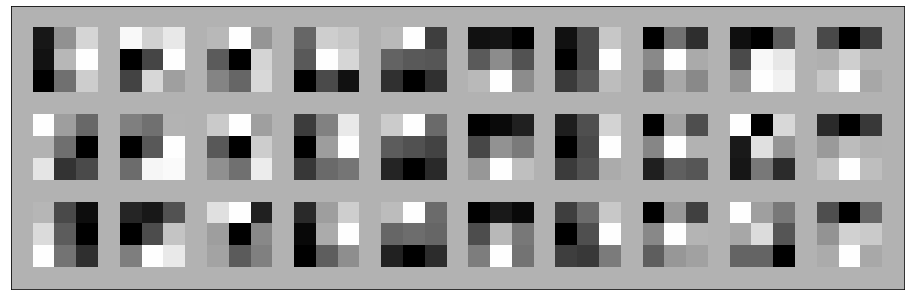

In [31]:
Image.open(io.BytesIO(fm.mkimage(kgrids[0][0]))), kgrids[0][1], kgrids[0][2] 

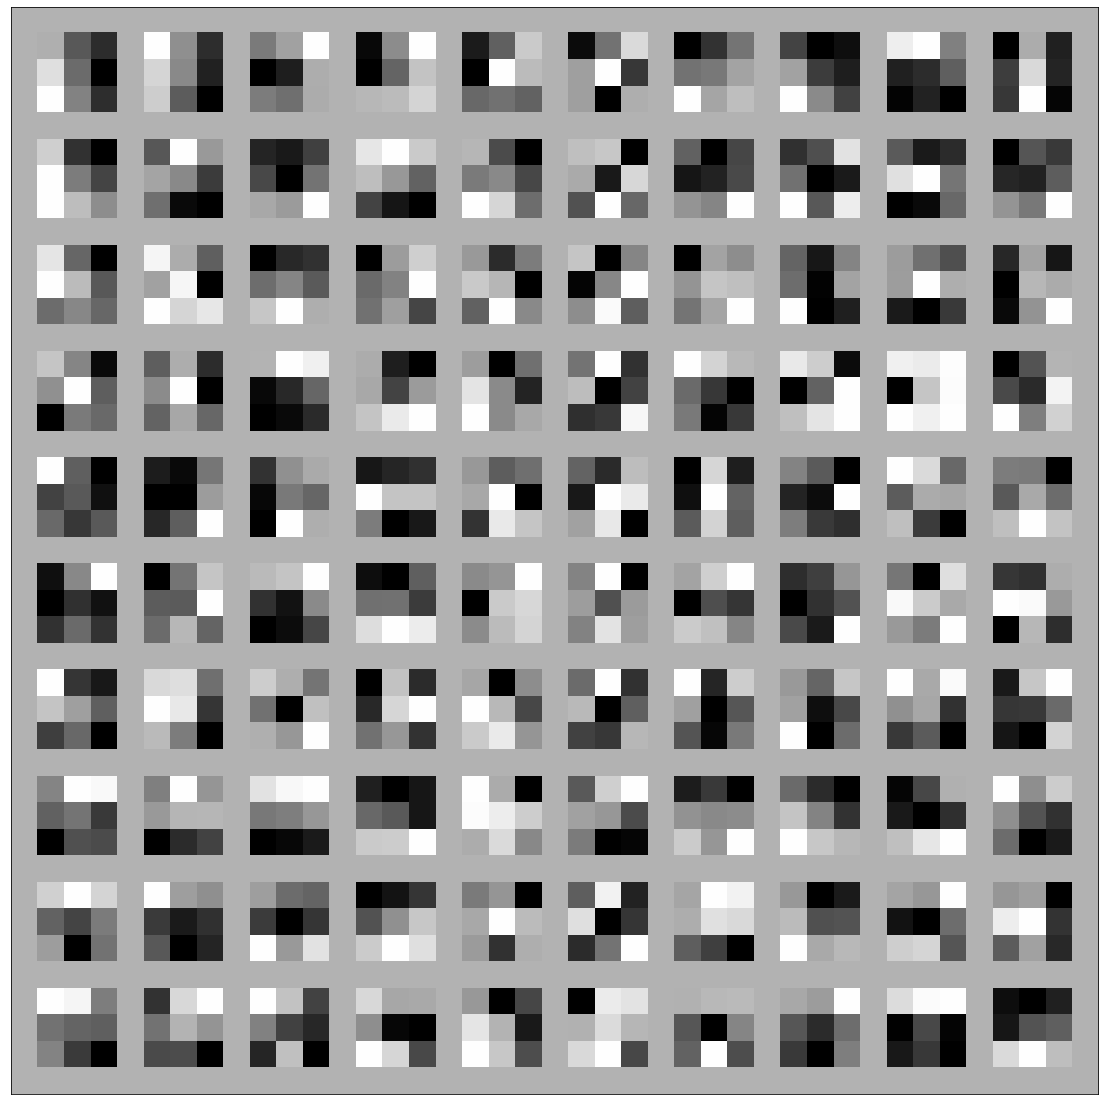

In [33]:
Image.open(io.BytesIO(fm.mkimage(kgrids[1][0], figsize=(20, 20)))), kgrids[1][1], kgrids[1][2]

(1440, 1440)

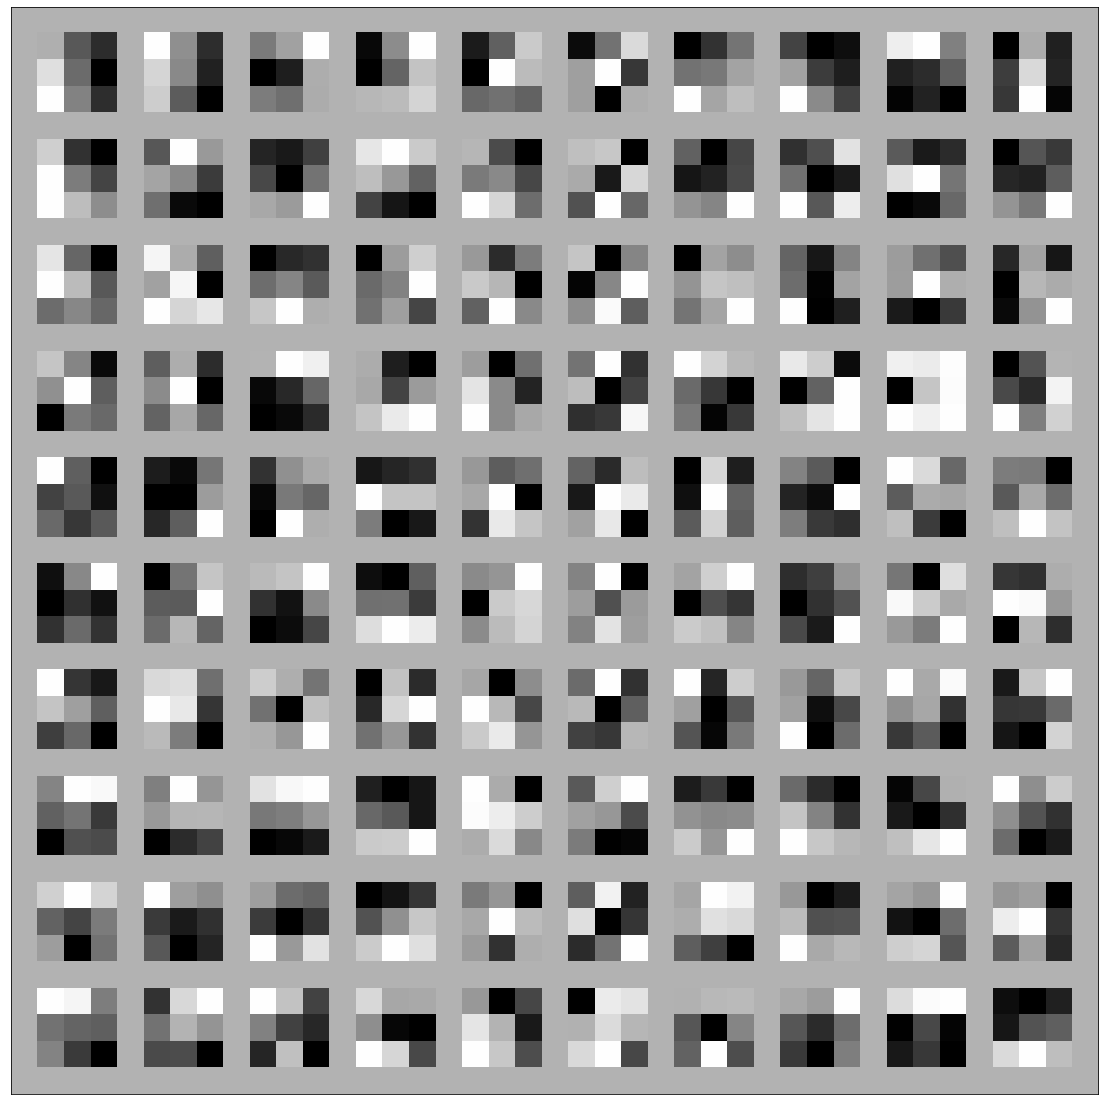

In [39]:
img = Image.open(io.BytesIO(fm.mkimage(kgrids[1][0], figsize=(20, 20))));
img.width, img.height